# Estudo de Abordagens Específicas de Crossover para DODAGs

Neste notebook exploramos algumas abordagens de Crossover para o caso particular dos DODAGs.

1. Crossover por Subárvores
    - Como o DODAG tem uma estrutura próxima de uma árvore, essa abordagem consiste em trocar subárvores enraizadas em diferentes nós dos pais.
2. Crossover por Nível Hierárquico
    - Divide os grafos pais em diferentes níveis hierárquicos e combina níveis de ambos para formar novos filhos.
3. Crossover por Mesclagem de Caminhos
    - Seleciona e combina diferentes caminhos direcionados que levam ao destino.
4. Crossover por Junção de Componentes
    - Divide o DODAG em componentes conectados menores e combina componentes de diferentes pais.

### Função para visualização de pares de Dígrafos

In [84]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches

def visualize(digraph1, digraph2, radius_of_reach, title1, title2):
    """Visualiza dois DODAGs lado a lado como digrafos com setas, com títulos personalizados."""
    
    # Recupera as posições para a plotagem
    pos1 = nx.get_node_attributes(digraph1, 'pos')
    pos2 = nx.get_node_attributes(digraph2, 'pos')

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # Subplots para colocar os gráficos lado a lado

    # Função para desenhar o digrafo com círculo
    def plot_graph(digraph, pos, ax, title, radius_of_reach):
        # Verifica se o nó 0 existe no dicionário de posições
        if 0 in pos:
            center = pos[0]
            circ = patches.Circle(
                center,
                radius_of_reach,
                fill=False,
                edgecolor='red',
                linestyle='--',
                linewidth=1
            )
            ax.add_patch(circ)
        
        # Plota o digrafo com setas
        nx.draw(digraph, pos, ax=ax, with_labels=True, node_size=300, node_color='lightblue', arrows=True)
        
        # Ajusta a proporção dos eixos para que sejam iguais
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(title)

    # Plota os dois digrafos lado a lado
    plot_graph(digraph1, pos1, ax[0], title1, radius_of_reach)
    plot_graph(digraph2, pos2, ax[1], title2, radius_of_reach)

    plt.tight_layout()  # Ajusta o layout para evitar sobreposição
    plt.show()
    
def visualize_digraphs(digraphs, titles, radius_of_reach, nrows=1, ncols=3):
    """
    Visualiza múltiplos DODAGs como dígrafos com setas, dispostos em uma grade.
    
    Parâmetros:
        digraphs (list): Lista de grafos do NetworkX a serem plotados.
        radius_of_reach (float): Raio de alcance para desenhar o círculo ao redor do nó 0.
        titles (list): Lista de títulos para cada grafo.
        nrows (int): Número de linhas da grade de subplots.
        ncols (int): Número de colunas da grade de subplots.
    """
    
    # Verifica se o número de títulos corresponde ao número de grafos
    assert len(digraphs) == len(titles), "O número de títulos deve ser igual ao número de dígrafos."
    
    # Cria a figura com subplots organizados em uma grade
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))
    
    # Se houver apenas uma linha ou coluna, converte axes para uma lista 1D
    axes = axes.flatten() if nrows * ncols > 1 else [axes]

    # Função interna para plotar cada grafo
    def plot_graph(digraph, ax, title, radius_of_reach):
        pos = nx.get_node_attributes(digraph, 'pos')
        
        # Verifica se o nó 0 existe no dicionário de posições
        if 0 in pos:
            center = pos[0]
            circ = patches.Circle(
                center,
                radius_of_reach,
                fill=False,
                edgecolor='red',
                linestyle='--',
                linewidth=1
            )
            ax.add_patch(circ)
        
        # Plota o digrafo com setas
        nx.draw(digraph, pos, ax=ax, with_labels=True, node_size=300, node_color='lightblue', arrows=True)
        
        # Ajusta a proporção dos eixos para que sejam iguais
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(title)
    
    # Itera sobre os grafos e suas respectivas posições nos subplots
    for i, (digraph, ax, title) in enumerate(zip(digraphs, axes, titles)):
        plot_graph(digraph, ax, title, radius_of_reach)
    
    # Remove subplots extras, se houver
    for j in range(len(digraphs), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()  # Ajusta o layout para evitar sobreposição
    plt.show()

    
def visualize_digraph(digraph, title):
    pos = nx.spring_layout(digraph)
    # Plota o digrafo com setas
    nx.draw(digraph, pos, with_labels=True, node_size=300, node_color='lightblue', arrows=True)
    
    # Ajusta a proporção dos eixos para que sejam iguais
    plt.gca().set_aspect("equal", adjustable="box")
    
    plt.title(title)
    plt.show()

In [98]:
import networkx as nx

def count_nodes_by_outdegree(digraph):
    """
    Retorna um vetor onde cada índice contém a quantidade de nós com aquele número de filhos (out-degree).
    
    Parâmetros:
        digraph (nx.DiGraph): Um dígrafo do NetworkX.
    
    Retorno:
        list: Um vetor onde o índice `i` contém a quantidade de nós com `i` filhos.
    """
    
    # Obtém o out-degree (número de filhos) de cada nó
    out_degrees = [digraph.in_degree(n) for n in digraph.nodes]
    
    # Encontra o maior out-degree para definir o tamanho do vetor
    max_out_degree = max(out_degrees)
    
    # Inicializa o vetor com zeros
    count_by_outdegree = [0] * (max_out_degree + 1)
    
    # Conta a quantidade de nós com cada out-degree
    for degree in out_degrees:
        count_by_outdegree[degree] += 1
    
    return count_by_outdegree

# Exemplo de uso
digraph = nx.DiGraph()
edges = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 5)]  # Exemplo de arestas
digraph.add_edges_from(edges)

result = count_nodes_by_outdegree(digraph)
print(result)  # Saída: [0, 3, 2]


[1, 5]


### Classe Modelo para construção de DODAGs

In [38]:
import random
import networkx as nx

class Node:
    def __init__(self, node_id, position, is_root=False):
        self.node_id = node_id
        self.position = position
        self.is_root = is_root
        self.rank = 0 if is_root else float('inf')  # Rank inicial (0 para a raiz)
        self.root_path_cost = 0 if is_root else float('inf')
        self.parent = None
        self.neighbors = []
        
    def receive_dio(self, sender):
        """Processa uma mensagem DIO de um vizinho."""
        new_rank = sender.rank + 1  
        dist = self.network.distance(self, sender)
        new_cost = sender.root_path_cost + dist            
        if new_cost < self.root_path_cost:  # Atualiza se o novo caminho for melhor
            self.rank = new_rank
            self.root_path_cost = new_cost
            self.parent = sender

class Network:
    def __init__(self, num_nodes, area_size, radius_of_reach):
        self.nodes = []
        self.graph = nx.Graph()
        self.area_size = area_size
        self.num_nodes = num_nodes
        self.radius_of_reach = radius_of_reach

    def create_network(self, positions=None):
        """Cria nós e estabelece vizinhança com base na distância.
        :param positions: Lista opcional de posições cartesianas [(x1, y1), (x2, y2), ...].
        """
        if positions and len(positions) != self.num_nodes:
            raise ValueError("O número de posições fornecidas deve ser igual ao número de nós.")

        for i in range(self.num_nodes):
            if positions and i in positions:
                position = positions[i]
            else:
                position = self.generate_valid_position_with_neighborwood(i)

            node = Node(node_id=i, position=position, is_root=(i == 0))
            node.network = self  # Referência à rede para cálculos
            self.nodes.append(node)
            self.graph.add_node(i, pos=node.position)

        # Estabelece conexões com base em distância
        for node in self.nodes:
            for neighbor in self.nodes:
                if node != neighbor and self.distance(node, neighbor) < self.radius_of_reach:
                    node.neighbors.append(neighbor)
                    self.graph.add_edge(node.node_id, neighbor.node_id)

    def generate_valid_position_with_neighborwood(self, id):
        """Gera nó e garante que tenha vizinhos no raio de alcance."""
        position = (random.randint(0, self.area_size), random.randint(0, self.area_size))
        if id > 0:
            not_neighbor = True
            while not_neighbor:
                position = (random.randint(0, self.area_size), random.randint(0, self.area_size))
                node = Node(node_id=id, position=position, is_root=False)
                for n in self.nodes:
                    if self.distance(n, node) < self.radius_of_reach:
                        not_neighbor = False
                        break
        return position
    
    def distance(self, node_a, node_b):
        """Calcula a distância euclidiana entre dois nós."""
        x1, y1 = node_a.position
        x2, y2 = node_b.position
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

    def propagate_dio(self):
        """Simula a propagação de mensagens DIO a partir da raiz."""
        queue = [self.nodes[0]]  # Começa com a raiz
        visited = set()  # Conjunto de nós visitados

        while queue:
            current = queue.pop(0)  # Retira o primeiro nó da fila
            if current.node_id in visited:
                continue  # Evita processar novamente

            visited.add(current.node_id)  # Marca o nó como visitado

            for neighbor in current.neighbors:
                if neighbor.node_id not in visited:  # Processa apenas não visitados
                    neighbor.receive_dio(current)
                    queue.append(neighbor)  # Adiciona à fila

    def get_digraph(self):
        """Visualiza o DODAG como um digrafo com setas."""
        digraph = nx.DiGraph()  # Digrafo para representar o DODAG

        # Adiciona os nós e arestas dirigidas com base no parent
        for node in self.nodes:
            digraph.add_node(node.node_id, pos=node.position)
            if node.parent is not None:
                digraph.add_edge(node.node_id, node.parent.node_id)

        return digraph

### Função de ajuste de posições para formação de DODAG

In [56]:
import numpy as np
from scipy.spatial.distance import cdist

def adjust_dodag(coords, radius, max_iterations=None, move_step=0.5, tol=1e-9):
    """
    Ajusta as coordenadas dos nós para formar uma rede DODAG (com nó 0 como raiz),
    garantindo que todos tenham caminho até a raiz dentro de um certo raio.

    Parâmetros:
        coords (list of tuple): Lista de coordenadas 2D [(x1, y1), (x2, y2), ...].
        radius (float): Raio de alcance para considerar dois nós conectados.
        max_iterations (int, opcional): Número máximo de iterações. Se None, usa 2*n.
        move_step (float, opcional): Fator de quanto o nó desconexo se move em direção
                                     ao nó mais próximo (0 < move_step <= 1).
                                     Se 1, move-se totalmente até ficar a (radius - 1)
                                     de distância do nó mais próximo.
                                     Se menor que 1, faz movimentos mais suaves.
        tol (float, opcional): Tolerância numérica para comparações de distância.

    Retorna:
        list: Lista de coordenadas ajustadas (como listas de floats).
    """
    # Conversão inicial
    coords = np.array(coords, dtype=float)
    n = len(coords)

    if max_iterations is None:
        max_iterations = 2 * n

    def get_connected_nodes(dist_matrix, radius):
        """
        Retorna uma lista booleana "connected" indicando, para cada nó,
        se ele é alcançável a partir do nó 0 via DFS, considerando
        distâncias <= radius (com tolerância).
        """
        visited = [False] * n

        def dfs(node):
            stack = [node]
            visited[node] = True
            while stack:
                curr = stack.pop()
                for neighbor in range(n):
                    # Verifica conexão com tolerância
                    if dist_matrix[curr][neighbor] <= radius + tol and not visited[neighbor]:
                        visited[neighbor] = True
                        stack.append(neighbor)

        # Inicia DFS a partir do nó 0
        dfs(0)
        return visited

    adjusted_coords = coords.copy()

    for _ in range(max_iterations):
        # 1. Calcula a matriz de distâncias apenas uma vez por iteração
        dist_matrix = cdist(adjusted_coords, adjusted_coords)

        # 2. Descobre quais nós estão conectados a partir da raiz
        connected = get_connected_nodes(dist_matrix, radius)

        # 3. Se todos estiverem conectados, encerra
        if all(connected):
            break

        # 4. Ajusta nós desconexos
        any_movement = False  # Para detectar se houve movimentação na iteração

        disconnected_nodes = [i for i in range(n) if not connected[i]]

        for i in disconnected_nodes:
            # Não permite mover a raiz (0)
            if i == 0: 
                continue

            # Escolhe o nó conectado mais próximo
            distances = dist_matrix[i]  # distância do nó i para todos
            # Ignora a si mesmo
            distances[i] = np.inf

            # Ignora outros nós desconexos, SE quisermos que somente nós conectados sejam alvo.
            # Descomente para proibir conexões entre nós desconexos:
            # for j in disconnected_nodes:
            #     distances[j] = np.inf

            # Verifica se existe algum nó conectado para nos aproximar
            connected_indices = [idx for idx, c in enumerate(connected) if c and idx != i]
            if not connected_indices:
                # Se nenhum nó está conectado (caso extremo), não há o que fazer.
                continue

            # Filtra distância somente para nós conectados
            for idx in range(n):
                if idx not in connected_indices:
                    distances[idx] = np.inf

            nearest_node = np.argmin(distances)
            dist_to_nearest = dist_matrix[i][nearest_node]

            # Se já estiver dentro do raio, não há necessidade de movimento
            if dist_to_nearest <= radius + tol:
                continue

            # Vetor do nó i para o nó mais próximo
            vector = adjusted_coords[nearest_node] - adjusted_coords[i]
            norm_vector = np.linalg.norm(vector)
            if norm_vector < tol:
                continue

            # Distância desejada é (radius - 1) para garantir alcance.
            desired_dist = max(radius - 1, 0) 
            delta = dist_to_nearest - desired_dist

            # Movimento será uma fração (move_step) do delta
            move_dist = move_step * delta

            # Vetor de movimento
            move_vector = (move_dist / norm_vector) * vector

            # Atualiza posição do nó i
            adjusted_coords[i] += move_vector
            any_movement = True

        # 5. Se não houve nenhuma movimentação nesta iteração, podemos encerrar
        if not any_movement:
            break

    return adjusted_coords.tolist()

### Função de Inicialização de População

In [68]:
def is_a_valid_position(position, positions, radius_of_reach, max_neighbors):
    # A primeira posição é sempre válida
    if len(positions) == 0:
        return True
    # Contar o número de nós dentro do raio de alcance
    neighbors_in_range = sum(
        ((position[0] - p[0])**2 + (position[1] - p[1])**2)**0.5 < radius_of_reach
        for p in positions
    )
    # Verificar se o número de vizinhos está dentro do limite
    valid_position = (
        neighbors_in_range <= max_neighbors
        and neighbors_in_range > 0
    )
    return valid_position

# Inicialização da população
def initialize_population(size, num_nodes, area_size, radius_of_reach, max_neighbors):
    population = []
    for _ in range(size):
        positions = []
        for i in range(num_nodes):
            valid_position = False
            while not valid_position:
                position = (random.randint(0, area_size), random.randint(0, area_size))
                valid_position = is_a_valid_position(position, positions, radius_of_reach, max_neighbors)
            positions.append(position)
        population.append(positions)
    return population

## Crossover por subárvores

Como o DODAG tem uma estrutura próxima de uma árvore, essa abordagem consiste em trocar subárvores enraizadas em diferentes nós dos pais.

### Abordagem Inicial

O exemplo a seguir serve apenas para ilustrar a operação propósta:

1. Selecionar aleatoriamente um nó em cada DODAG pai.
2. Extrair a subárvore enraizada nesses nós.
3. Trocar as subárvores entre os pais para gerar os filhos.
4. Ajustar arestas para manter a conectividade ao destino.

DODAG 1 original: [(0, 1), (0, 2), (1, 3), (1, 4)]
DODAG 2 original: [(0, 5), (0, 6), (5, 7), (6, 8)]


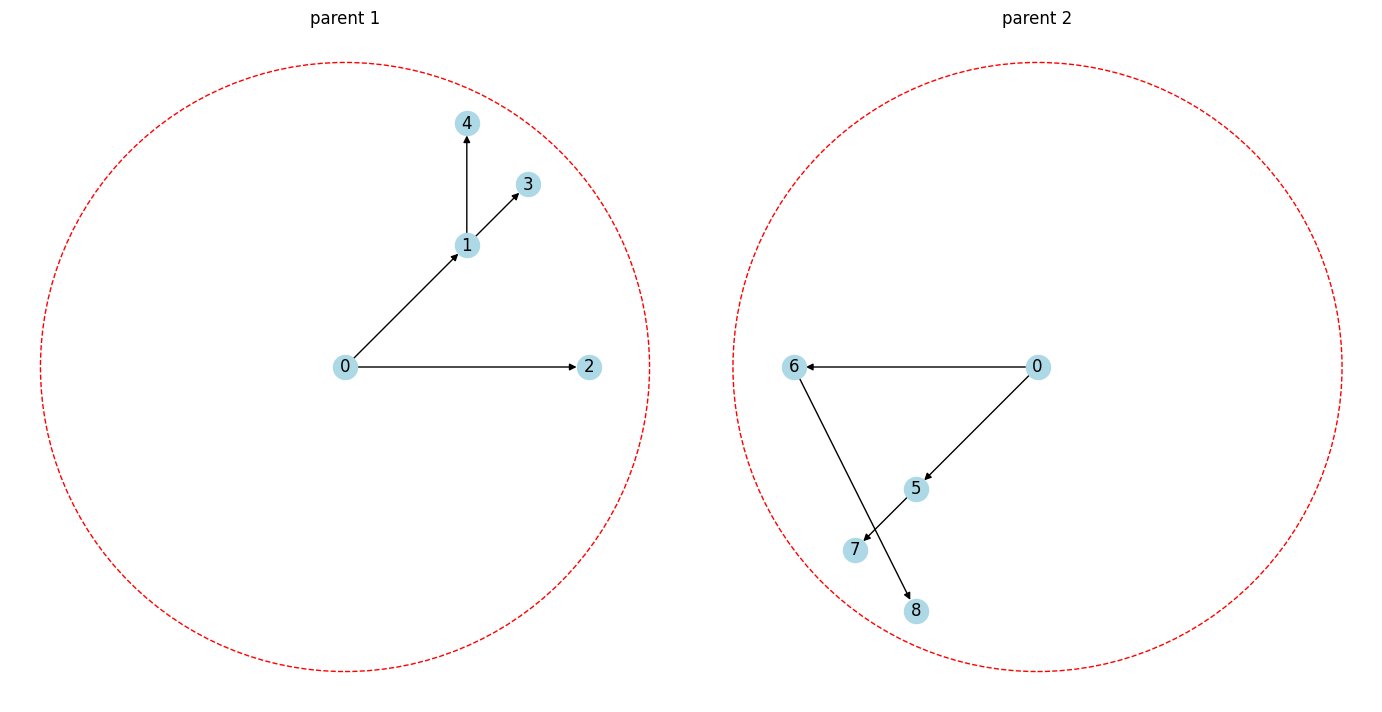

DODAG 1 filho: [(0, 1), (0, 2), (0, 8), (0, 6), (1, 4), (6, 8)]
DODAG 2 filho: [(0, 5), (0, 3), (5, 7)]


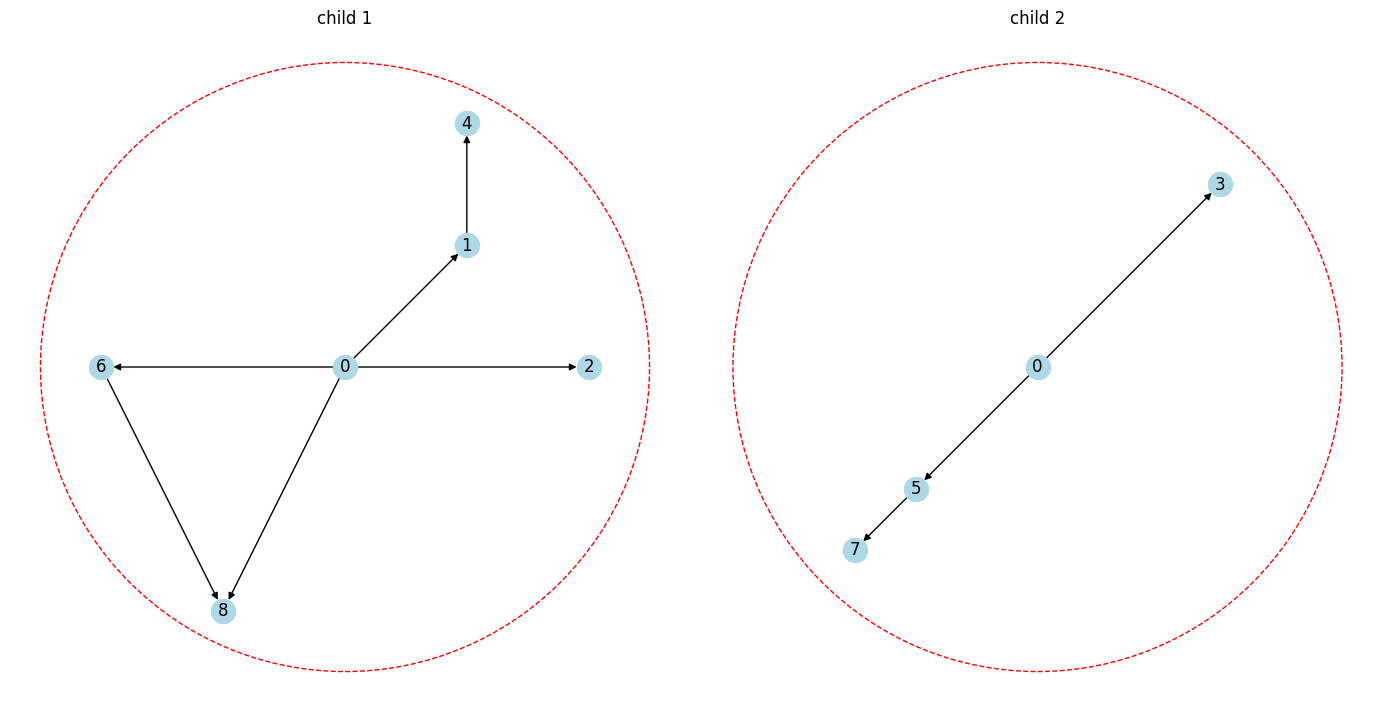

In [50]:
import networkx as nx
import random
import math

def euclidean_distance(graph, node1, node2):
    """Calcula a distância euclidiana entre dois nós usando o atributo 'pos'."""
    pos1 = graph.nodes[node1].get('pos', (0, 0))  # Posição do nó1
    pos2 = graph.nodes[node2].get('pos', (0, 0))  # Posição do nó2
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def extract_subtree(graph, root):
    """Extrai a subárvore enraizada no nó `root`."""
    subtree_nodes = nx.descendants(graph, root) | {root}
    subtree = graph.subgraph(subtree_nodes).copy()
    return subtree

def reconnect_within_radius(graph, subtree, radius, root=0):
    """Reconecta a subárvore ao nó raiz (0) garantindo o raio de alcance."""
    for node in subtree:
        if node != root and euclidean_distance(graph, root, node) <= radius:
            graph.add_edge(root, node)

def crossover_subtrees_with_radius(dodag1, dodag2, radius):
    """Realiza o crossover por subárvores entre dois DODAGs considerando posições e raio."""
    
    # Seleciona um nó aleatório que não seja a raiz (0)
    root1 = random.choice([n for n in dodag1.nodes if n != 0])
    root2 = random.choice([n for n in dodag2.nodes if n != 0])
    
    # Extrai as subárvores enraizadas nos nós selecionados
    subtree1 = extract_subtree(dodag1, root1)
    subtree2 = extract_subtree(dodag2, root2)
    
    # Remove os nós das subárvores selecionadas (exceto a raiz)
    dodag1.remove_nodes_from(subtree1.nodes - {0})
    dodag2.remove_nodes_from(subtree2.nodes - {0})
    
    # Adiciona as subárvores trocadas
    dodag1 = nx.compose(dodag1, subtree2)
    dodag2 = nx.compose(dodag2, subtree1)
    
    # Reconecta as subárvores ao nó raiz (0) respeitando o raio de alcance
    reconnect_within_radius(dodag1, subtree2.nodes, radius)
    reconnect_within_radius(dodag2, subtree1.nodes, radius)
    
    # Verifica se os grafos resultantes ainda são acíclicos
    assert nx.is_directed_acyclic_graph(dodag1), "DODAG 1 resultante tem ciclos!"
    assert nx.is_directed_acyclic_graph(dodag2), "DODAG 2 resultante tem ciclos!"
    
    # Retorna os dois novos DODAGs filhos
    return dodag1, dodag2

# Exemplo de uso
if __name__ == "__main__":
    # Criando dois DODAGs de exemplo com posições no atributo 'pos'
    dodag1 = nx.DiGraph()
    dodag1.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4)])
    dodag1.nodes[0]['pos'] = (0, 0)
    dodag1.nodes[1]['pos'] = (1, 1)
    dodag1.nodes[2]['pos'] = (2, 0)
    dodag1.nodes[3]['pos'] = (1.5, 1.5)
    dodag1.nodes[4]['pos'] = (1, 2)
    
    dodag2 = nx.DiGraph()
    dodag2.add_edges_from([(0, 5), (0, 6), (5, 7), (6, 8)])
    dodag2.nodes[0]['pos'] = (0, 0)
    dodag2.nodes[5]['pos'] = (-1, -1)
    dodag2.nodes[6]['pos'] = (-2, 0)
    dodag2.nodes[7]['pos'] = (-1.5, -1.5)
    dodag2.nodes[8]['pos'] = (-1, -2)
    
    radius = 2.5  # Definindo o raio de alcance
    
    # Exibe os DODAGs originais
    print("DODAG 1 original:", dodag1.edges)
    print("DODAG 2 original:", dodag2.edges)
    visualize(dodag1, dodag2, radius, "parent 1", "parent 2")
    
    # Realiza o crossover
    child1, child2 = crossover_subtrees_with_radius(dodag1, dodag2, radius)
    
    # Exibe os DODAGs filhos
    print("DODAG 1 filho:", child1.edges)
    print("DODAG 2 filho:", child2.edges)
    
    visualize(child1, child2, radius, "child 1", "child 2")


### Utilizando Modelo DODAG

O exemplo a seguir utiliza a classe Network para construir uma rede DODAG. Ajustamos os filhos para serem reconstruídos na topologia DODAG. No entanto, observe que os filhos podem ter uma quantidade de nós diferente dos pais.

DODAG 1 original: [(1, 0), (2, 0), (3, 0), (4, 15), (15, 0), (5, 0), (6, 3), (7, 0), (8, 1), (9, 4), (10, 0), (11, 7), (12, 0), (13, 24), (24, 4), (14, 12), (16, 24), (17, 0), (18, 4), (19, 13), (20, 19), (21, 8), (22, 20), (23, 0), (25, 6), (26, 6), (27, 0), (28, 14), (29, 22), (30, 5)]
DODAG 2 original: [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 4), (7, 0), (8, 0), (9, 0), (10, 17), (17, 2), (11, 2), (12, 2), (13, 12), (14, 4), (15, 28), (28, 11), (16, 12), (18, 12), (19, 21), (21, 17), (20, 28), (22, 12), (23, 0), (24, 0), (25, 4), (26, 16), (27, 30), (30, 7), (29, 18)]


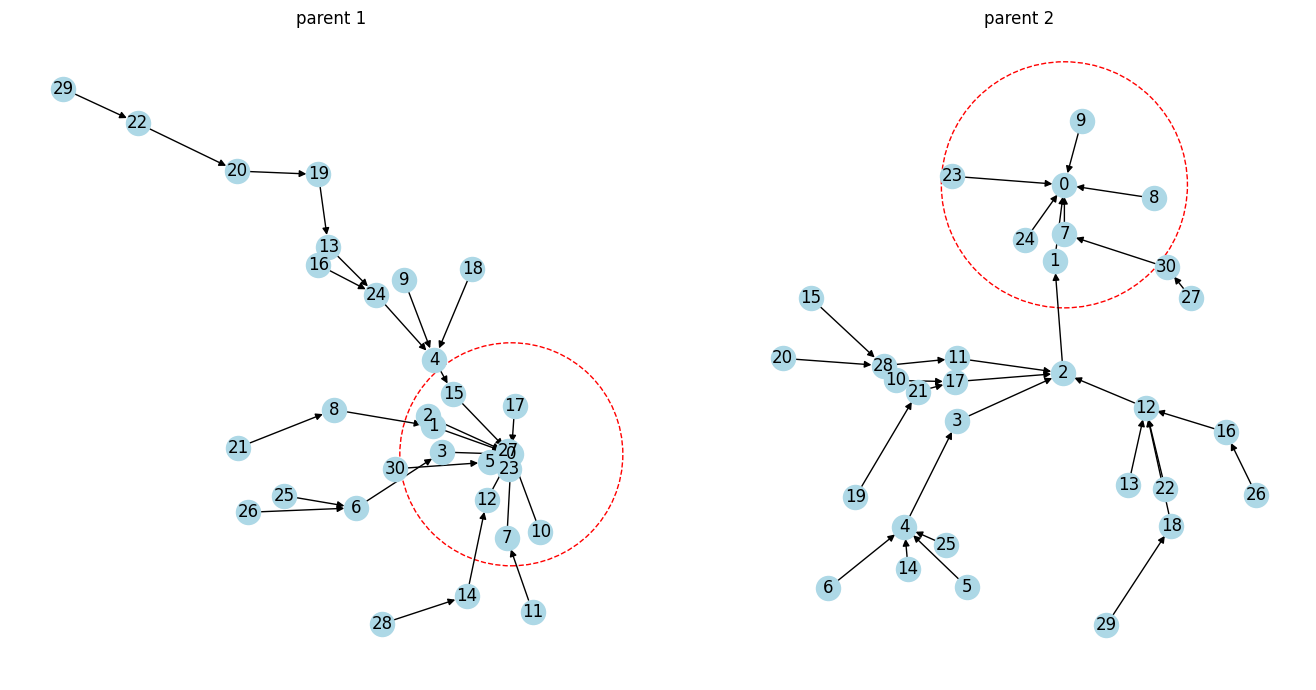

DODAG 1 filho: [(1, 0), (2, 0), (3, 0), (4, 3), (5, 2), (6, 0), (7, 2), (8, 9), (9, 0), (10, 4), (11, 5), (12, 10), (13, 0), (14, 4), (15, 17), (17, 0), (16, 11), (18, 10), (19, 14), (20, 4), (21, 17), (22, 4), (23, 11)]
DODAG 2 filho: [(1, 0), (2, 1), (3, 0), (4, 1), (5, 0), (6, 22), (22, 0), (7, 0), (8, 0), (9, 10), (10, 0), (11, 26), (26, 3), (12, 11), (13, 9), (14, 0), (15, 4), (16, 11), (17, 12), (18, 12), (19, 17), (20, 0), (21, 0), (23, 8), (24, 9), (25, 15), (27, 17)]


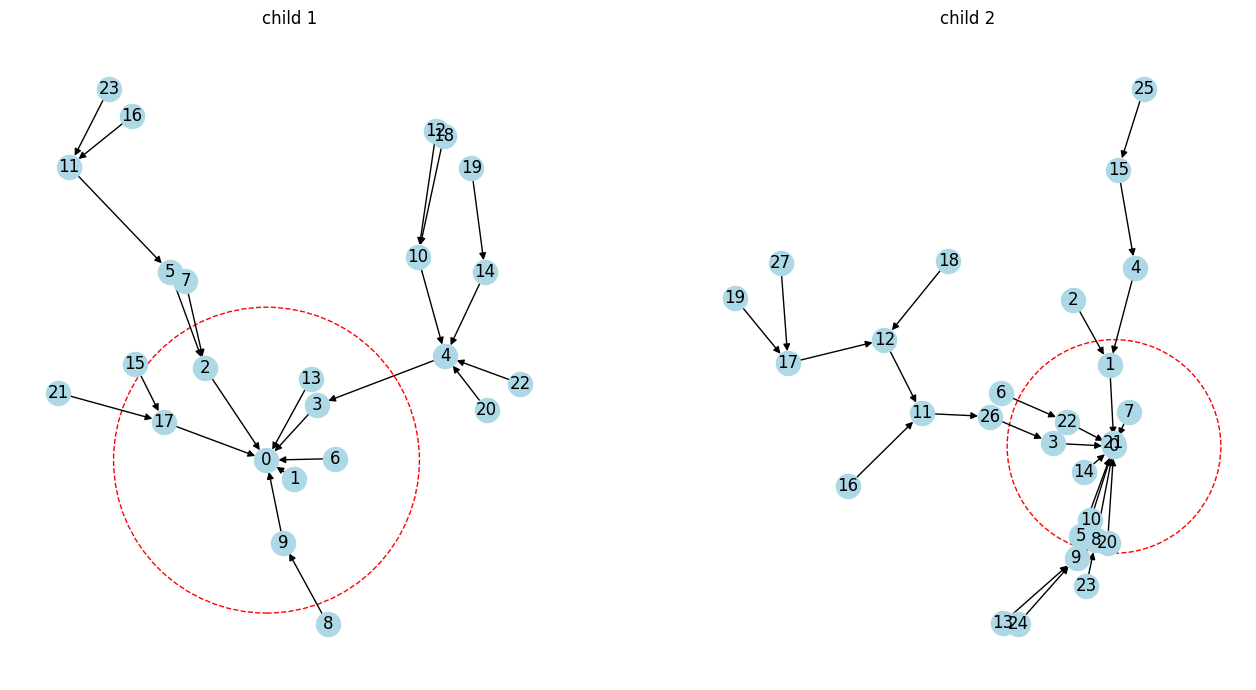

In [96]:
import networkx as nx
import random
import math

def euclidean_distance(graph, node1, node2):
    """Calcula a distância euclidiana entre dois nós usando o atributo 'pos'."""
    pos1 = graph.nodes[node1].get('pos', (0, 0))  # Posição do nó1
    pos2 = graph.nodes[node2].get('pos', (0, 0))  # Posição do nó2
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def extract_subtree(graph, root):
    """Extrai a subárvore enraizada no nó `root`."""
    subtree_nodes = nx.descendants(graph, root) | {root}
    subtree = graph.subgraph(subtree_nodes).copy()
    return subtree

def rename_nodes(dodag):
    """Renomeia os nós do DODAG, mantendo o nó 0 e renumerando os demais a partir de 1."""
    # Cria um mapeamento dos nós, mantendo o nó 0 com o mesmo valor
    node_mapping = {0: 0}
    new_id = 1
    for node in dodag.nodes:
        if node != 0:
            node_mapping[node] = new_id
            new_id += 1
    
    # Renomeia os nós de acordo com o mapeamento
    dodag = nx.relabel_nodes(dodag, node_mapping)
    
    return dodag

def crossover_subtrees_with_radius(dodag1, dodag2, radius):
    """Realiza o crossover por subárvores entre dois DODAGs considerando posições e raio."""
    
    # Seleciona um nó aleatório que não seja a raiz (0)
    root1 = random.choice([n for n in dodag1.nodes if n != 0])
    root2 = random.choice([n for n in dodag2.nodes if n != 0])
    
    # Extrai as subárvores enraizadas nos nós selecionados
    subtree1 = extract_subtree(dodag1, root1)
    subtree2 = extract_subtree(dodag2, root2)
    
    # Remove os nós das subárvores selecionadas (exceto a raiz)
    dodag1.remove_nodes_from(subtree1.nodes - {0})
    dodag2.remove_nodes_from(subtree2.nodes - {0})
    
    # Adiciona as subárvores trocadas
    dodag1 = nx.compose(dodag1, subtree2)
    dodag2 = nx.compose(dodag2, subtree1)
    
    # Renomeia os nós nos DODAGs resultantes
    dodag1 = rename_nodes(dodag1)
    dodag2 = rename_nodes(dodag2)
    
    # Retorna os dois novos DODAGs filhos
    return dodag1, dodag2

# Exemplo de uso
if __name__ == "__main__":
    # Parâmetros da rede
    NUM_NODES = 31
    AREA_SIZE = 1000
    RADIUS_OF_REACH = 100

    pop = initialize_population(2, NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, 3)

    # Criação e simulação da rede 1
    network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)
    network.create_network(positions=pop[0])
    network.propagate_dio()
    
    dodag1 = network.get_digraph()
    
    # Criação e simulação da rede 2
    network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)
    network.create_network(positions=pop[0])
    network.propagate_dio()
    
    dodag2 = network.get_digraph()
        
    # Exibe os DODAGs originais
    print("DODAG 1 original:", dodag1.edges)
    print("DODAG 2 original:", dodag2.edges)
    
    visualize(dodag1, dodag2, RADIUS_OF_REACH, "parent 1", "parent 2")
    
    # Realiza o crossover
    child1, child2 = crossover_subtrees_with_radius(dodag1.copy(), dodag2.copy(), RADIUS_OF_REACH)
        
    pos1 = nx.get_node_attributes(child1, 'pos')
    pos2 = nx.get_node_attributes(child2, 'pos')
    
    pos1 = adjust_dodag(list(pos1.values()), radius=RADIUS_OF_REACH)
    pos2 = adjust_dodag(list(pos2.values()), radius=RADIUS_OF_REACH)
    
    network = Network(len(pos1), AREA_SIZE, RADIUS_OF_REACH)
    network.create_network(positions=pos1)
    network.propagate_dio()
    result1 = network.get_digraph()
    
    network = Network(len(pos2), AREA_SIZE, RADIUS_OF_REACH)
    network.create_network(positions=pos2)
    network.propagate_dio()
    result2 = network.get_digraph()
        
    # Exibe os DODAGs filhos
    print("DODAG 1 filho:", result1.edges)
    print("DODAG 2 filho:", result2.edges)
    
    visualize(result1, result2, RADIUS_OF_REACH, "child 1", "child 2")

#### Comparando com método simples de crossover.

Observe que no final apresentamos as contagens de graus de saída dos dígrafos, note que comparando os pais com os filhos utilizando o método crossover por subárvores, aparentemente os filhos conservam mais da topologia dos pais em relação ao método de crossover apenas sobre os pontos. Este método de crossover mais simples apresenta uma distribuição mais uniforme, sem nós com graus muito altos. Isso indica que ele não preserva tanto a hierarquia dos pais, mas sim promove uma distribuição balanceada de graus de saída, resultando em maior diversidade estrutural.

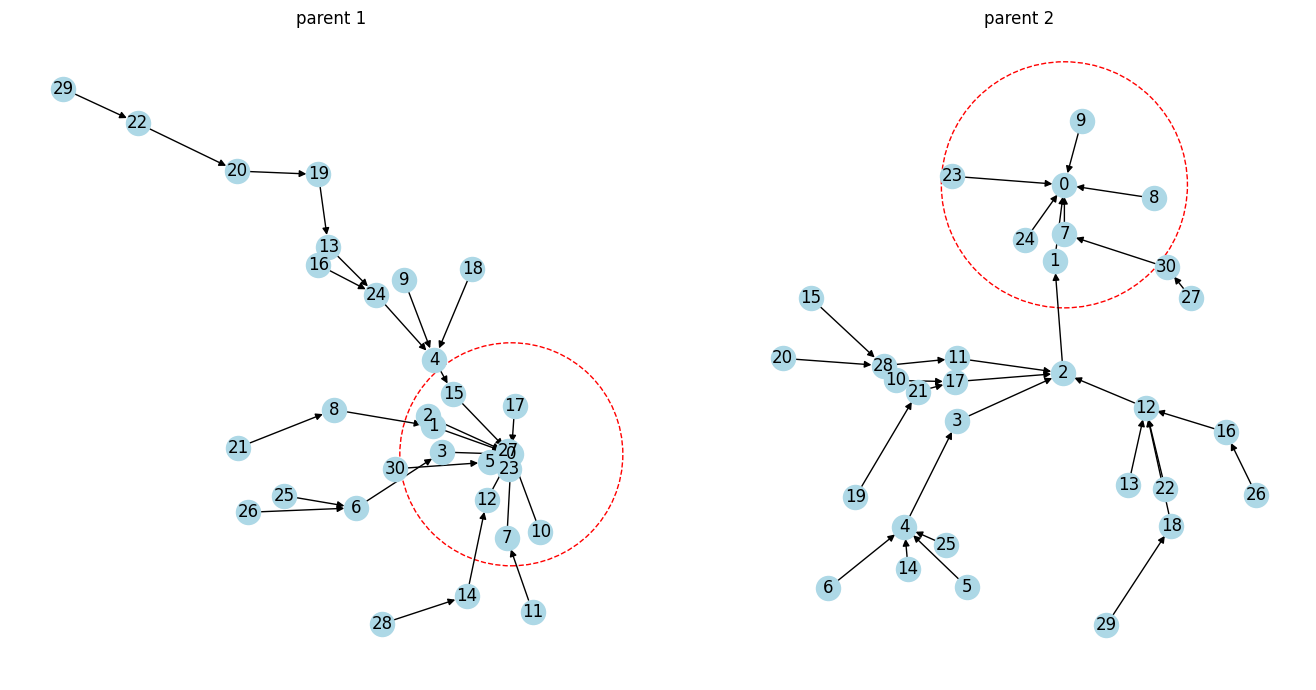

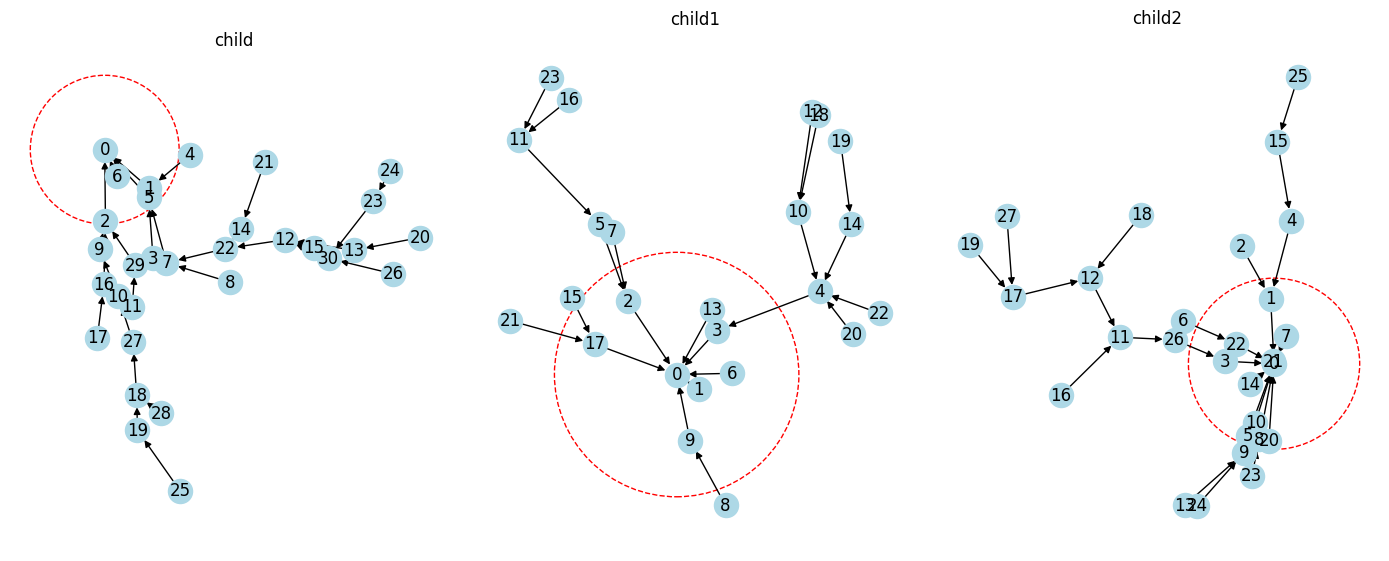

[15, 12, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1]
[17, 8, 2, 0, 3, 0, 1]
[14, 4, 4, 0, 1, 0, 0, 1]
[15, 7, 5, 0, 0, 0, 0, 0, 0, 0, 1]
[13, 10, 5, 2, 1]


In [ ]:
def crossover(parent1, parent2):
    r = [
        ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
        for p1, p2 in zip(parent1, parent2)
    ]
    return r

visualize(dodag1, dodag2, RADIUS_OF_REACH, "parent 1", "parent 2")

pos1 = nx.get_node_attributes(dodag1, 'pos')
pos2 = nx.get_node_attributes(dodag2, 'pos')

# Realiza o crossover
child = crossover(list(pos1.values()), list(pos2.values()))
    
pos1 = adjust_dodag(child, radius=RADIUS_OF_REACH)

network = Network(len(pos1), AREA_SIZE, RADIUS_OF_REACH)
network.create_network(positions=pos1)
network.propagate_dio()
result = network.get_digraph()
    
visualize_digraphs([result, result1, result2], ["child", "child1", "child2"], RADIUS_OF_REACH)

print(count_nodes_by_outdegree(dodag1))
print(count_nodes_by_outdegree(dodag2))
print(count_nodes_by_outdegree(result1))
print(count_nodes_by_outdegree(result2))
print(count_nodes_by_outdegree(result))


#### Melhoria na adição dos vertices faltantes pós cruzamento

Semelhante à comparação precedente, observamos que este conserva parte da estrutura dos pais, porém também apresenta uma distribuição mais balanceada em relação ao anterior.

DODAG 1 original: [(1, 0), (2, 0), (3, 0), (4, 15), (15, 0), (5, 0), (6, 3), (7, 0), (8, 1), (9, 4), (10, 0), (11, 7), (12, 0), (13, 24), (24, 4), (14, 12), (16, 24), (17, 0), (18, 4), (19, 13), (20, 19), (21, 8), (22, 20), (23, 0), (25, 6), (26, 6), (27, 0), (28, 14), (29, 22), (30, 5)]
DODAG 2 original: [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 4), (7, 0), (8, 0), (9, 0), (10, 17), (17, 2), (11, 2), (12, 2), (13, 12), (14, 4), (15, 28), (28, 11), (16, 12), (18, 12), (19, 21), (21, 17), (20, 28), (22, 12), (23, 0), (24, 0), (25, 4), (26, 16), (27, 30), (30, 7), (29, 18)]


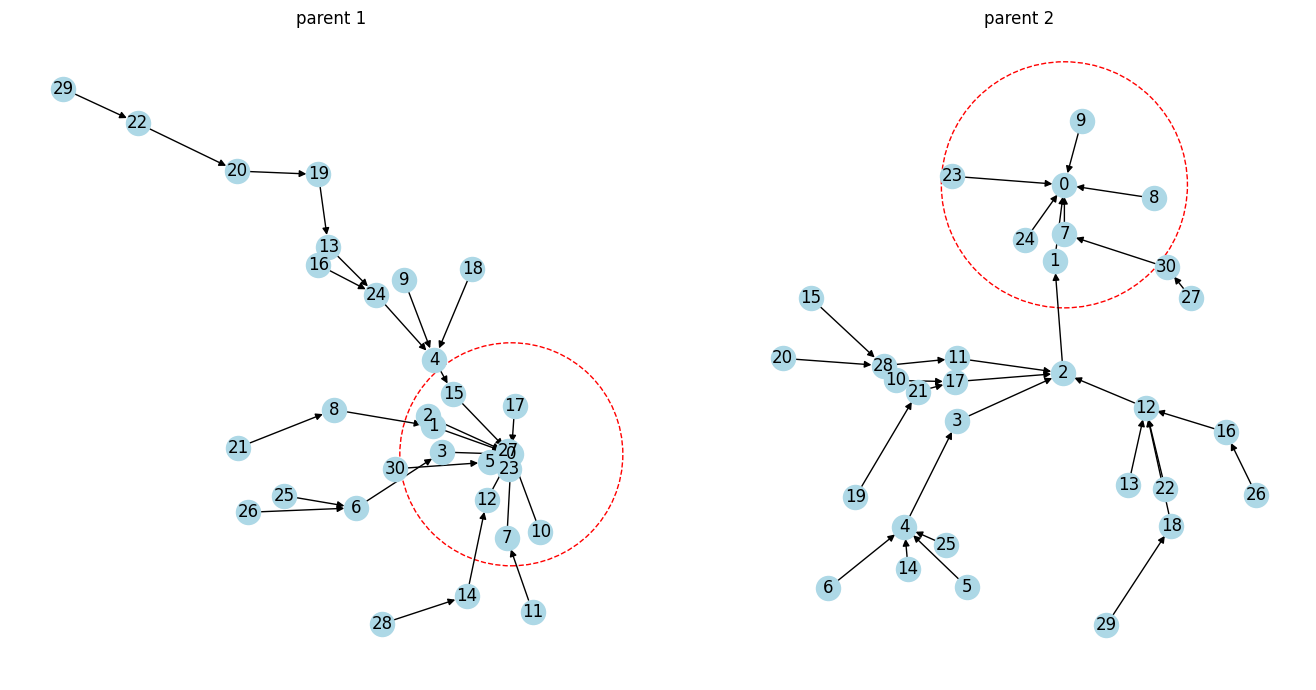

DODAG 1 filho: [(1, 0), (2, 0), (3, 1), (4, 11), (11, 0), (5, 0), (6, 2), (7, 1), (8, 2), (9, 1), (10, 11), (12, 27), (27, 2), (13, 14), (14, 1), (15, 12), (16, 8), (17, 29), (29, 27), (18, 1), (19, 2), (20, 17), (21, 22), (22, 2), (23, 18), (24, 29), (25, 15), (26, 14), (28, 0), (30, 14)]
DODAG 2 filho: [(1, 0), (2, 0), (3, 30), (30, 0), (4, 24), (24, 0), (5, 30), (6, 0), (7, 21), (21, 26), (8, 3), (9, 8), (10, 20), (20, 0), (11, 1), (12, 21), (13, 6), (14, 6), (15, 21), (16, 1), (17, 3), (18, 5), (19, 5), (26, 0), (22, 17), (23, 0), (25, 28), (28, 0), (27, 14), (29, 27)]


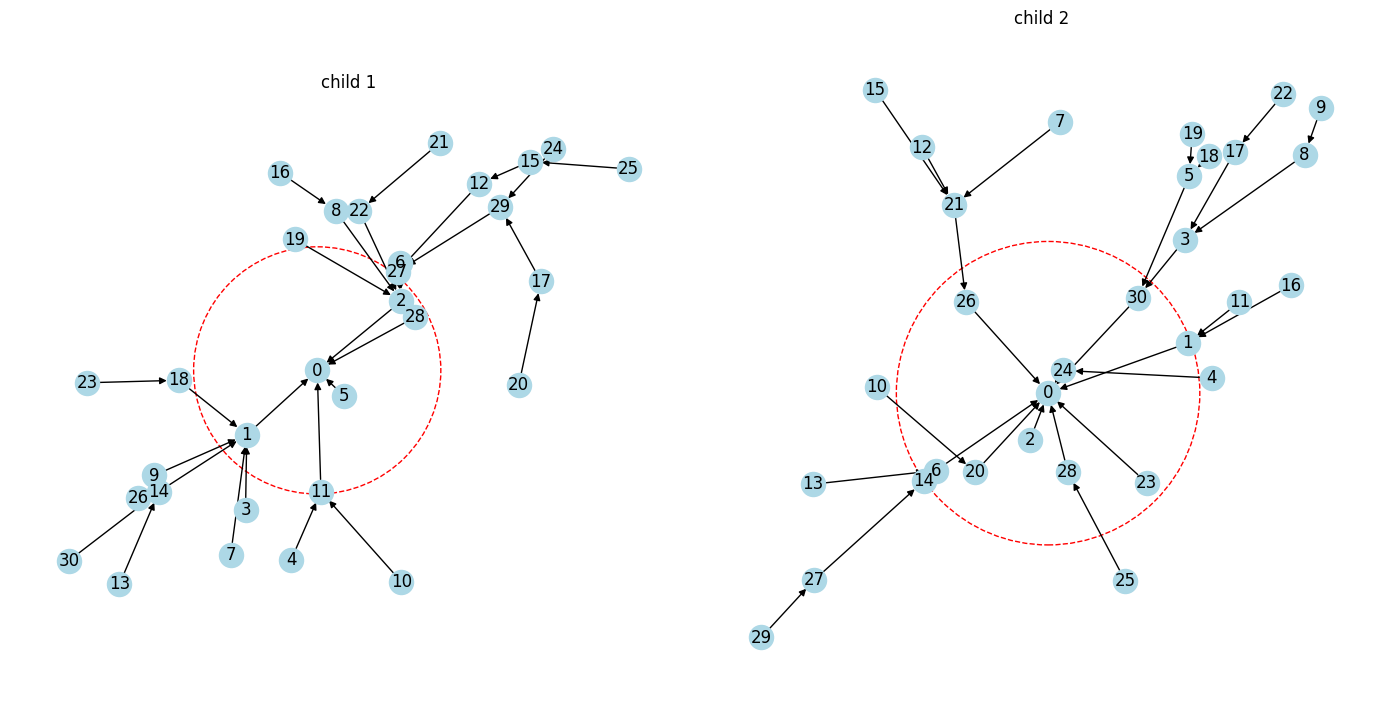

[15, 7, 1, 0, 0, 0, 0, 0, 0, 0, 1]
[16, 6, 2, 0, 3, 1]
[18, 6, 3, 1, 0, 3]
[16, 8, 5, 1, 0, 0, 0, 0, 0, 1]
[13, 10, 5, 2, 1]


In [100]:
import networkx as nx
import random
import math

def euclidean_distance(graph, node1, node2):
    """Calcula a distância euclidiana entre dois nós usando o atributo 'pos'."""
    pos1 = graph.nodes[node1].get('pos', (0, 0))  # Posição do nó1
    pos2 = graph.nodes[node2].get('pos', (0, 0))  # Posição do nó2
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def extract_subtree(graph, root):
    """Extrai a subárvore enraizada no nó `root`."""
    subtree_nodes = nx.descendants(graph, root) | {root}
    subtree = graph.subgraph(subtree_nodes).copy()
    return subtree

def rename_nodes(dodag):
    """Renomeia os nós do DODAG, mantendo o nó 0 e renumerando os demais a partir de 1."""
    # Cria um mapeamento dos nós, mantendo o nó 0 com o mesmo valor
    node_mapping = {0: 0}
    new_id = 1
    for node in dodag.nodes:
        if node != 0:
            node_mapping[node] = new_id
            new_id += 1
    
    # Renomeia os nós de acordo com o mapeamento
    dodag = nx.relabel_nodes(dodag, node_mapping)
    
    return dodag

def is_covered(graph, point, radius):
    for node in graph.nodes:
        pos1 = graph.nodes[node].get('pos', (0, 0))
        dist = math.sqrt((pos1[0] - point[0])**2 + (pos1[1] - point[1])**2)
        if dist < radius:
            return True
    return False

def add_random_nodes(graph, num_nodes, radius, area_size):
    """Adiciona nós aleatórios ao grafo até que tenha 'num_nodes' nós."""
    current_nodes = len(graph.nodes)
    for i in range(current_nodes, num_nodes):
        node_id = i
        graph.add_node(node_id)
        included = False
        while not included:
            # A posição dos nós aleatórios será gerada aleatoriamente dentro do intervalo pos_range
            new_pos = (random.randint(0, area_size), random.randint(0, area_size))
            included = is_covered(graph, new_pos, radius)
            if included:
                graph.nodes[node_id]['pos'] = new_pos

def crossover_subtrees_with_radius(dodag1, dodag2, radius, num_nodes, area_size):
    """Realiza o crossover por subárvores entre dois DODAGs considerando posições e raio."""
    
    # Seleciona um nó aleatório que não seja a raiz (0)
    root1 = random.choice([n for n in dodag1.nodes if n != 0])
    root2 = random.choice([n for n in dodag2.nodes if n != 0])
    
    # Extrai as subárvores enraizadas nos nós selecionados
    subtree1 = extract_subtree(dodag1, root1)
    subtree2 = extract_subtree(dodag2, root2)
    
    # Remove os nós das subárvores selecionadas (exceto a raiz)
    dodag1.remove_nodes_from(subtree1.nodes - {0})
    dodag2.remove_nodes_from(subtree2.nodes - {0})
    
    # Adiciona as subárvores trocadas
    dodag1 = nx.compose(dodag1, subtree2)
    dodag2 = nx.compose(dodag2, subtree1)
    
    # Renomeia os nós nos DODAGs resultantes
    dodag1 = rename_nodes(dodag1)
    dodag2 = rename_nodes(dodag2)
    
    # Garantir que ambos os grafos tenham num_nodes nós
    if len(dodag1.nodes) < num_nodes:
        add_random_nodes(dodag1, num_nodes, radius, area_size)
    if len(dodag2.nodes) < num_nodes:
        add_random_nodes(dodag2, num_nodes, radius, area_size)
    
    # Retorna os dois novos DODAGs filhos
    return dodag1, dodag2

    
# Exibe os DODAGs originais
print("DODAG 1 original:", dodag1.edges)
print("DODAG 2 original:", dodag2.edges)

visualize(dodag1, dodag2, RADIUS_OF_REACH, "parent 1", "parent 2")

# Realiza o crossover
child1, child2 = crossover_subtrees_with_radius(dodag1, dodag2, RADIUS_OF_REACH, NUM_NODES, AREA_SIZE)
    
pos1 = nx.get_node_attributes(child1, 'pos')
pos2 = nx.get_node_attributes(child2, 'pos')

pos1 = adjust_dodag(list(pos1.values()), radius=RADIUS_OF_REACH)
pos2 = adjust_dodag(list(pos2.values()), radius=RADIUS_OF_REACH)

network = Network(len(pos1), AREA_SIZE, RADIUS_OF_REACH)
network.create_network(positions=pos1)
network.propagate_dio()
result1 = network.get_digraph()

network = Network(len(pos2), AREA_SIZE, RADIUS_OF_REACH)
network.create_network(positions=pos2)
network.propagate_dio()
result2 = network.get_digraph()
    
# Exibe os DODAGs filhos
print("DODAG 1 filho:", result1.edges)
print("DODAG 2 filho:", result2.edges)

visualize(result1, result2, RADIUS_OF_REACH, "child 1", "child 2")

print(count_nodes_by_outdegree(dodag1))
print(count_nodes_by_outdegree(dodag2))
print(count_nodes_by_outdegree(result1))
print(count_nodes_by_outdegree(result2))
print(count_nodes_by_outdegree(result))